In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import gc
import time
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, ReLU, Activation)
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
df["file_name"] = df["id"].apply(lambda x: x + ".tif")
sample_size = 80000
df_pos = df.loc[df["label"] == 1, :].sample(n=sample_size)
df_neg = df.loc[df["label"] == 0, :].sample(n=sample_size)
df = pd.concat([df_pos, df_neg], ignore_index=True)
del df_pos, df_neg
df["label"] = df["label"].astype(str)

2024-06-23 20:57:05.488082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 20:57:05.488214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 20:57:05.654503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path_test = "../input/histopathologic-cancer-detection/test"
if not os.path.exists(path_test):
    raise ValueError(f"Test directory '{path_test}' does not exist.")
if not os.listdir(path_test):
    raise ValueError(f"Test directory '{path_test}' is empty. Please check the path or the files.")
    # Create DataFrame with test file names
test_files = [x for x in os.listdir(path_test)]
test_files = pd.DataFrame({"file_name": test_files})
len_test = len(test_files)

# Check if test_files DataFrame is empty
if test_files.empty:
    raise ValueError("The test_files DataFrame is empty. Please check the test file names.")
print("hello")
print(test_files.head())

hello
                                      file_name
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [3]:
df_train, df_val = train_test_split(df, test_size=0.1, stratify=df["label"])
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
len_train = df_train.shape[0]
len_val = df_val.shape[0]
print(f"Training data size: {len_train}.")
print(f"Validation data size: {len_val}.")
del df
gc.collect()

Training data size: 144000.
Validation data size: 16000.


62

In [4]:
img_gen_params = {
    "rescale": 1.0 / 255,
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "horizontal_flip": True,
    "vertical_flip": True
}
img_gen = ImageDataGenerator(**img_gen_params)
IMAGE_SHAPE = (96, 96, 3)
path_train = "../input/histopathologic-cancer-detection/train"
batch_size = 32
img_flow_params_train = {
    "dataframe": df_train,
    "directory": path_train,
    "x_col": "file_name",
    "y_col": "label",
    "has_ext": True,
    "target_size": IMAGE_SHAPE[:2],
    "batch_size": batch_size,
    "class_mode": 'binary'
}
img_flow_train = img_gen.flow_from_dataframe(**img_flow_params_train)
img_flow_params_val = {
    "dataframe": df_val,
    "directory": path_train,
    "x_col": "file_name",
    "y_col": "label",
    "has_ext": True,
    "target_size": IMAGE_SHAPE[:2],
    "batch_size": 1,
    "shuffle": False,
    "class_mode": 'binary'
}
img_flow_val = img_gen.flow_from_dataframe(**img_flow_params_val)

Found 144000 validated image filenames belonging to 2 classes.
Found 16000 validated image filenames belonging to 2 classes.


In [5]:
kernel_size = (5, 5)
filters = (32, 64, 128)
drop_prob_conv = 0.3
drop_prob_dense = 0.3
model = Sequential()
model.add(Conv2D(filters[0], kernel_size, padding="same", kernel_initializer='he_normal', input_shape=IMAGE_SHAPE))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[0], kernel_size, padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())
model.add(Dropout(drop_prob_conv))
model.add(Conv2D(filters[1], kernel_size, padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[1], kernel_size, padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())
model.add(Dropout(drop_prob_conv))
model.add(Conv2D(filters[2], kernel_size, padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[2], kernel_size, padding="same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())
model.add(Dropout(drop_prob_conv))
model.add(Flatten())
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_prob_dense))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_prob_dense))
model.add(Dense(1, activation="sigmoid"))
model.compile(Adam(0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1, mode='max')
lr_decay_params = {
    "monitor": "val_accuracy",
    "factor": 0.5,
    "patience": 1,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)
for i in range(5):
    x, y = next(img_flow_val)
    print(f"Batch {i+1}: x shape: {x.shape}, y: {y}")

# Ensure validation steps are correct
print(f"Expected validation steps: {len_val}")
print(f"Validation batch size: {img_flow_val.batch_size}")

Batch 1: x shape: (1, 96, 96, 3), y: [0.]
Batch 2: x shape: (1, 96, 96, 3), y: [1.]
Batch 3: x shape: (1, 96, 96, 3), y: [1.]
Batch 4: x shape: (1, 96, 96, 3), y: [1.]
Batch 5: x shape: (1, 96, 96, 3), y: [1.]
Expected validation steps: 16000
Validation batch size: 1


In [7]:
print("Training the model...")
model.fit(
    img_flow_train,
    steps_per_epoch=len_train // batch_size,
    epochs=1,
    verbose=1,
    validation_data=img_flow_val,
    validation_steps=len_val,
    callbacks=[lr_decay, early_stopping]
)
print("Done!")

Training the model...
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11110s 2s/step - accuracy: 0.7923 - loss: 0.4589 - val_accuracy: 0.7554 - val_loss: 0.4785 - learning_rate: 0.0100
Done!


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 392s 24ms/step
Validation accuracy: 0.756.
Validation AUC: 0.923.


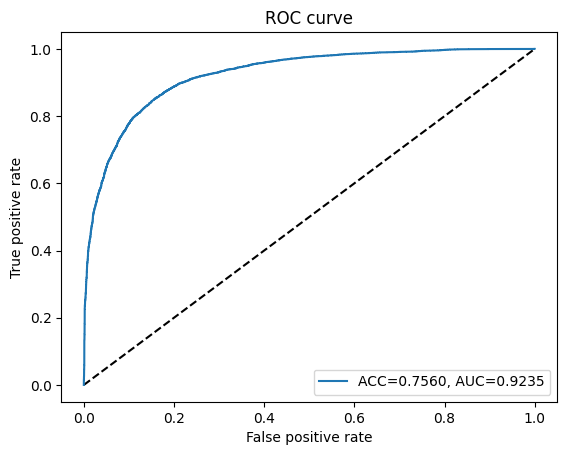

4085

<Figure size 640x480 with 0 Axes>

In [8]:
y_val_pred = model.predict(img_flow_val, steps=len_val)[:, 0]
y_val_true = img_flow_val.classes
acc_val = np.equal((y_val_pred > 0.5).astype("int"), y_val_true).sum() / y_val_pred.shape[0]
print(f"Validation accuracy: {acc_val:.3f}.")
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
auc_val = auc(fpr, tpr)
print(f"Validation AUC: {auc_val:.3f}.")
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label=f"ACC={acc_val:.4f}, AUC={auc_val:.4f}")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="best")
plt.show()
plt.savefig("roc_curve.png")
del img_flow_params_train, img_flow_params_val
gc.collect()

In [9]:
try:
    img_gen_params = {
        "rescale": 1.0 / 255,
        "samplewise_center": True,
        "samplewise_std_normalization": True,
        "horizontal_flip": True,
        "vertical_flip": True
    }
    img_gen = ImageDataGenerator(**img_gen_params)
    path_test = "../input/histopathologic-cancer-detection/test"
    if not os.path.exists(path_test):
        raise ValueError(f"Test directory '{path_test}' does not exist.")
    if not os.listdir(path_test):
        raise ValueError(f"Test directory '{path_test}' is empty. Please check the path or the files.")
    df_test = [x for x in os.listdir(path_test)]
    df_test = pd.DataFrame({"file_name": df_test})
    len_test = len(df_test)
    IMAGE_SHAPE = (96, 96, 3)
    bs = 32
    img_flow_params_test = {
        "dataframe": df_test,
        "directory": path_test,
        "x_col": "file_name",
        "has_ext": True,
        "class_mode": None,
        "target_size": IMAGE_SHAPE[:2],
        "batch_size": bs,
        "shuffle": False
    }
    img_flow_test = img_gen.flow_from_dataframe(**img_flow_params_test)
    y_pred = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
    y_pred["id"] = y_pred["id"].apply(lambda x: x + ".tif")
    test_run = 1
    len_test = len(df_test)
    for i in range(test_run):
        preds = model.predict(img_flow_test, steps=len_test, verbose=1)
        file_names = img_flow_test.filenames
        ind_y_pred = pd.DataFrame({"id": file_names, "label" + str(i + 1): preds[:, 0]})
        y_pred = y_pred.merge(ind_y_pred, on="id")
    y_pred["label"] = y_pred[["label" + str(i + 1) for i in range(test_run)]].mean(axis=1)
    y_pred.drop(["label" + str(i + 1) for i in range(test_run)], axis=1, inplace=True)
    y_pred["id"] = y_pred["id"].apply(lambda x: x.split(".")[0])
    y_pred.to_csv("y_pred.csv", index=False)
except:
    base_test_dir = '../input/histopathologic-cancer-detection/test/'
    test_files = glob(os.path.join(base_test_dir, '*.tif'))
    submission = pd.DataFrame()
    file_batch = 5000
    max_idx = len(test_files)

    for idx in range(0, max_idx, file_batch):
        print(f"Indexes: {idx} - {idx + file_batch}")
        test_df = pd.DataFrame({'path': test_files[idx:idx + file_batch]})
        test_df['id'] = test_df['path'].map(lambda x: os.path.basename(x).split(".")[0])
        test_df['image'] = test_df['path'].map(imread)
        K_test = np.stack(test_df["image"].values)
        K_test = (K_test - K_test.mean()) / K_test.std()
        predictions = model.predict(K_test)
        test_df['label'] = predictions
        submission = pd.concat([submission, test_df[["id", "label"]]])

    submission['id'] = submission['id'].apply(lambda x: x.split(".")[0])
    submission.to_csv("y_pred.csv", index=False)
    print(submission.head())

Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 1036s 18ms/step   
